<center> <h1>PREDICCIÓN DEL SUEÑO</h1> </center>
<center> <h3>CREACIÓN SUBCONJUNTOS DE TRAIN Y TEST</h3> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza</h4> </center>

### Índice de contenidos de este Notebook

En este Notebook se realiza la separación del dataframe en los subgrupos de Train y Test. Como primera aproximación se ha decidido trabajar con un total de 50 ventanas por sujeto y no con todas, por cuestiones de tiempo de ejecución.

    1. Creación de los conjuntos Train y Test
    2. Preparación datos de entrada y salida

In [1]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

Se carga el dataframe creado con las características extraídas de todos los sujetos:

In [2]:
df= pd.read_csv('features.csv')

In [3]:
df.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
21374,71.0,72.0,71.67,1.00,-0.11,-0.09,-0.10,0.34,0.35,0.34,-0.93,-0.92,-0.93,1.0,1.0,26.0
9177,57.0,59.0,57.33,1.00,0.54,0.55,0.54,0.20,0.21,0.20,-0.82,-0.81,-0.81,2.0,1.0,10.0
23702,80.0,85.0,84.00,1.00,-0.43,-0.43,-0.43,-0.77,-0.76,-0.77,-0.48,-0.47,-0.47,5.0,0.0,28.0
22116,67.0,68.0,67.83,0.99,-0.35,-0.33,-0.34,0.21,0.23,0.22,-0.92,-0.90,-0.91,2.0,1.0,26.0
566,57.0,58.0,57.60,1.00,0.27,0.27,0.27,0.86,0.86,0.86,-0.44,-0.43,-0.43,3.0,1.0,0.0
906,61.0,62.0,61.83,1.00,0.07,0.08,0.08,-0.44,-0.43,-0.43,-0.90,-0.89,-0.90,3.0,1.0,1.0
8517,68.0,70.0,69.00,0.99,0.28,0.72,0.62,-0.31,0.86,0.51,-0.94,-0.36,-0.55,0.0,0.0,10.0
3399,49.0,50.0,49.29,1.00,-0.17,-0.17,-0.17,0.07,0.07,0.07,-0.99,-0.98,-0.98,1.0,1.0,3.0
12184,74.0,86.0,78.50,1.02,-0.36,0.17,0.12,-1.10,0.18,-0.01,-0.91,1.06,0.87,5.0,0.0,14.0
5260,82.0,82.0,82.00,1.00,-0.72,-0.13,-0.19,-1.16,-0.22,-0.79,-1.04,0.60,0.39,2.0,1.0,5.0


## 1. Creación de los conjuntos Train y Test

Se crean 2 listas aleatorias con una **proporción de 3:1** para Train y Test.

In [4]:
lista = list(range(31)) # Lista de 31 números
suj_train = sample(lista,k=24) # 21 sujetos de train
suj_test = [el for el in lista if el not in suj_train] #Los que no están en train van a test (7)

print(len(suj_train),'sujetos de train:',suj_train)
print(len(suj_test),'sujetos de test:',suj_test)

24 sujetos de train: [17, 30, 16, 11, 18, 25, 0, 27, 19, 8, 13, 1, 6, 21, 28, 23, 29, 4, 10, 7, 22, 26, 14, 12]
7 sujetos de test: [2, 3, 5, 9, 15, 20, 24]


Con cada una de las listas de sujetos anteriores, se crean los conjuntos de Train y Test de manera que no se mezclen los sujetos entre cada uno de los dos subconjuntos:

In [5]:
train_matr = []
test_matr = []
id = df['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    train_matr.append(m)

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    test_matr.append(m)

En este caso, los conjuntos de Train y Test se han creado con **50 ventanas** deslizantes y no con todas.

In [6]:
lista_ventanas=list(np.linspace(0,0.9,50)) #[0,1/10,1/5,3/10,4/10,5/10,6/10,7/10,8/10,9/10]

Train = pd.DataFrame()  
for i in range(len(train_matr)):
    lista_multi=[int(element * len(train_matr[i])) for element in lista_ventanas]
    ven1=train_matr[i].iloc[lista_multi]
    Train=Train.append(ven1)

Test = pd.DataFrame()  
for i in range(len(test_matr)):
    lista_multi=[int(element * len(test_matr[i])) for element in lista_ventanas]
    ven2=test_matr[i].iloc[lista_multi]
    Test=Test.append(ven2)

In [7]:
Train.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
13875,51.0,61.0,54.17,1.00,-0.20,-0.19,-0.20,0.02,0.02,0.02,0.98,0.99,0.98,5.0,0.0,16.0
18845,54.0,55.0,54.33,1.00,-0.35,-0.35,-0.35,0.02,0.03,0.02,-0.94,-0.93,-0.93,2.0,1.0,23.0
11002,88.0,90.0,89.29,0.99,-0.22,-0.21,-0.21,0.11,0.13,0.12,-0.96,-0.95,-0.96,3.0,1.0,13.0
11563,86.0,87.0,86.50,1.00,0.45,0.47,0.46,-0.29,-0.28,-0.29,-0.84,-0.83,-0.83,4.0,1.0,14.0
15511,68.0,71.0,69.50,1.00,0.09,0.10,0.09,0.95,0.96,0.96,0.27,0.28,0.28,2.0,1.0,19.0
6738,89.0,97.0,93.00,1.00,-0.18,-0.17,-0.18,0.50,0.51,0.51,-0.84,-0.84,-0.84,2.0,1.0,7.0
21792,69.0,72.0,71.43,0.99,-0.36,-0.35,-0.36,0.54,0.55,0.54,-0.76,-0.75,-0.75,2.0,1.0,26.0
15485,72.0,73.0,72.83,1.00,0.05,0.06,0.06,0.65,0.67,0.66,-0.75,-0.74,-0.75,0.0,0.0,19.0
9446,50.0,51.0,50.20,0.99,-0.34,-0.33,-0.34,0.28,0.29,0.29,-0.89,-0.89,-0.89,3.0,1.0,11.0
1004,68.0,70.0,68.50,1.00,0.78,0.79,0.78,-0.04,-0.04,-0.04,-0.62,-0.61,-0.62,3.0,1.0,1.0


In [16]:
Test.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
19929,75.0,77.0,76.00,1.00,-0.37,-0.36,-0.36,-0.46,-0.44,-0.45,-0.82,-0.81,-0.82,3.0,1.0,24.0
20086,63.0,65.0,64.00,0.99,-0.24,-0.23,-0.23,-0.37,-0.36,-0.36,0.89,0.90,0.90,5.0,0.0,24.0
1875,66.0,70.0,68.17,1.00,0.25,0.25,0.25,-0.73,-0.72,-0.73,-0.65,-0.64,-0.64,3.0,1.0,2.0
5164,47.0,48.0,47.43,1.00,-0.13,-0.10,-0.12,-0.24,-0.22,-0.23,-0.97,-0.95,-0.96,2.0,1.0,5.0
12390,63.0,64.0,63.83,0.99,-0.29,-0.28,-0.29,-0.88,-0.87,-0.88,0.37,0.37,0.37,3.0,1.0,15.0
4938,46.0,47.0,46.33,1.00,0.25,0.26,0.26,-0.74,-0.73,-0.73,0.61,0.63,0.62,5.0,0.0,5.0
16396,45.0,49.0,48.14,1.00,-0.31,-0.29,-0.30,-0.13,-0.11,-0.12,-0.96,-0.94,-0.94,2.0,1.0,20.0
20225,61.0,63.0,62.40,1.00,0.17,0.17,0.17,0.33,0.34,0.33,-0.93,-0.93,-0.93,2.0,1.0,24.0
2949,53.0,54.0,53.29,1.00,0.30,0.32,0.31,-0.16,-0.12,-0.15,-0.95,-0.94,-0.94,0.0,0.0,3.0
20329,63.0,67.0,64.17,1.00,-0.30,-0.29,-0.29,-0.11,-0.10,-0.11,0.94,0.95,0.95,5.0,0.0,24.0


In [9]:
Train.to_csv('Train.csv', header=True, index=False)
Test.to_csv('Test.csv', header=True, index=False)

COMPARAR LOS DOS SUBCONJUNTOS

HISTOGRAMA DATOS TRAIN


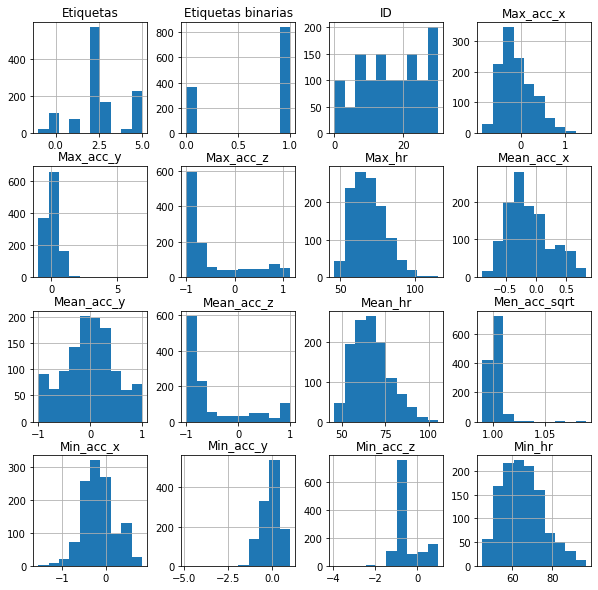

In [10]:
print(chr(27)+"[1;34m"+'HISTOGRAMA DATOS TRAIN')
Train.hist(figsize=(10, 10))
plt.show()

In [11]:
Train.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,65.184167,68.755000,66.867317,0.997158,-0.157058,-0.088000,-0.118625,-0.082467,0.032908,-0.020517,-0.526550,-0.440733,-0.489733,2.441667,0.697500,16.125000
std,10.133154,11.081997,10.449957,0.006687,0.374788,0.379939,0.353255,0.521459,0.552285,0.477477,0.635105,0.636338,0.615217,1.532499,0.459532,8.888675
min,45.000000,46.000000,45.670000,0.990000,-1.540000,-0.880000,-0.880000,-4.870000,-0.990000,-1.000000,-3.930000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,58.000000,60.000000,58.830000,0.990000,-0.420000,-0.360000,-0.380000,-0.410000,-0.332500,-0.350000,-0.920000,-0.880000,-0.890000,2.000000,0.000000,9.500000
50%,64.000000,67.000000,65.670000,1.000000,-0.220000,-0.160000,-0.190000,-0.050000,0.030000,0.000000,-0.820000,-0.780000,-0.800000,2.000000,1.000000,16.500000
75%,71.000000,76.000000,73.200000,1.000000,0.070000,0.110000,0.090000,0.250000,0.330000,0.290000,-0.292500,-0.070000,-0.247500,3.000000,1.000000,23.500000
max,97.000000,115.000000,105.330000,1.090000,0.820000,1.490000,0.830000,0.990000,6.880000,0.990000,0.990000,1.150000,1.000000,5.000000,1.000000,30.000000


HISTOGRAMA DATOS TEST


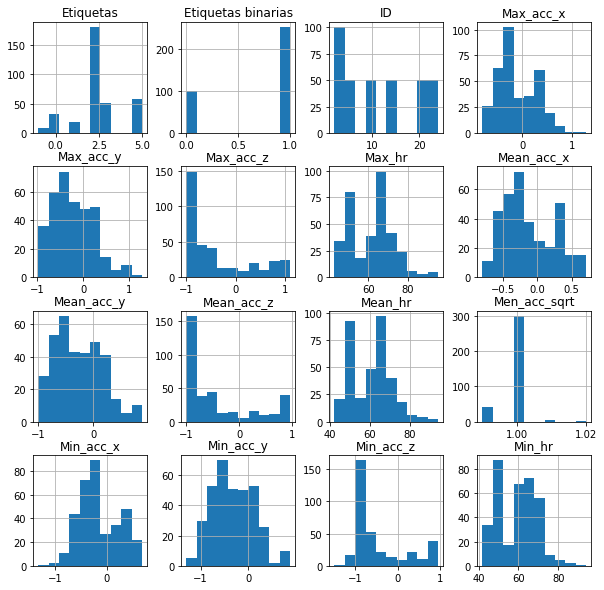

In [12]:
print(chr(27)+"[1;34m"+'HISTOGRAMA DATOS TEST')
Test.hist(figsize=(10, 10))
plt.show()

In [13]:
Test.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,59.311429,61.885714,60.478914,0.999057,-0.157543,-0.093314,-0.123857,-0.310257,-0.218914,-0.263200,-0.471857,-0.380657,-0.430543,2.337143,0.714286,11.142857
std,9.440062,10.612399,9.805639,0.003856,0.383352,0.379092,0.365128,0.434058,0.451043,0.420498,0.645323,0.659302,0.640573,1.485573,0.452401,8.036959
min,42.000000,43.000000,42.330000,0.990000,-1.330000,-0.790000,-0.800000,-1.300000,-0.980000,-0.990000,-1.500000,-1.000000,-1.000000,-1.000000,0.000000,2.000000
25%,50.000000,51.000000,50.500000,1.000000,-0.450000,-0.380000,-0.400000,-0.647500,-0.580000,-0.590000,-0.940000,-0.900000,-0.920000,2.000000,0.000000,3.000000
50%,61.000000,64.000000,62.670000,1.000000,-0.240000,-0.190000,-0.230000,-0.360000,-0.270000,-0.330000,-0.800000,-0.640000,-0.740000,2.000000,1.000000,9.000000
75%,66.000000,68.000000,67.127500,1.000000,0.177500,0.250000,0.205000,0.042500,0.117500,0.077500,-0.192500,0.047500,-0.077500,3.000000,1.000000,20.000000
max,94.000000,95.000000,94.000000,1.020000,0.680000,1.280000,0.710000,0.870000,1.270000,0.870000,0.960000,1.100000,0.960000,5.000000,1.000000,24.000000


TAREAS:
- ¿Normalizar?
- Añadir feature: proxy de reloj
- 